<h3 align="center"> Unsupervised Learning Capstone -  Classification of Bloggers</h3> 

__Contents__<a name="top"></a>
1. [Summary of Results](#sum)
1. [Dataset  Description and Notes](#describe)
1. [Objective](#object)
1. [Example XML Files](#xml)
2. [Cleaning and Processing Data](#clean)
 - [process01 Function](#pro1)
 - [process02 Function](#pro2)
 - [process03 Function](#pro3)
3. [Create Dataframe and Save to File](#file)

### Analysis Summary  <a name="sum"></a>

The [dataset](#describe) utilized includes 19,000+ blogger's posts along with some additional features such as gender and age.  Natural Language Processing (NLP) techiques were used to develop features from the post content.  While the Unsupervised modeling method of clustering was proscribed as the initial claassifier, supervised classifiers were also utilized to understand the results.  

The initial objective of the analysis included: 

1. Indentify the individual bloggers from the features developed from the posts.  
2. Classify a bloggers gender and age from the features developed from the posts.

For objective 1, a dataset was developed 

The initial idea for the for the period feature was that it may work in combination with the LSA features when the classification targets were "age" or "gender".

### Dataset  Description and Notes <a name="describe"></a>

Here is the
The main reason that I choose this dataset is beyond the text provided by the blog posts, there are four additonal features of gender, age, occupation and sign that can be targeted. I will admit that maybe the idea of using a horoscope sign feature for a target intrigued me more than it should.  

The dataset includes:

- There are 19,322 xml files that vary greatly in size. Some lack the values for the occupation feature.  While most of the xml values required cleaning before they could be parsed, some had to be discarded because they were no where near *"well formed"*.
- To develop a classifier model that targets blogger, I used the 10 largest files.
- Seperate classifer models that target the other four features are developed from  a set of 200 files with a size of around 25 kb.  That seem to give me a reasonable amount of post samples for each blogger.  I did not use a file that lacked an occupation value nor any with an age of 21 or less.   
- Sort xml files by size and select about 200 files in the 25k byte range that have a reasonable amount of text / blog entries
-  Filter out files that don't have info for all features.  Filter out bloggers with age less than 25. 
-  *import lxml.etree as ET* not xml.etree due to decoding issues in the xml files
- Some xml files still have decoding issues and are not used. 

*Please cite the following if you use the data:*

J. Schler, M. Koppel, S. Argamon and J. Pennebaker (2006). Effects of Age and Gender on Blogging in Proceedings of 2006 AAAI Spring Symposium on Computational Approaches for Analyzing Weblogs.
 

### Dataset Cleaning and Processing

The cleaning and parsing of the xml files along with the NLP processing of the post text is accomplished in separate notebook due to the time involved. The end products as DataFrames were saved to files and loaded into this notebook.  This is the link. [040501 Data](https://pages.github.com/)

In [1]:
import pandas as pd
import numpy as np
from string import ascii_uppercase
import random

In [2]:
# load DataFrames from Data notebook 
dfa = pd.read_csv(r'data/dfa.csv', index_col = 0, header=0)
dfa.date = pd.to_datetime(dfa.date)
dfb = pd.read_csv(r'data/dfb.csv', index_col = 0, header=0)
dfb.date = pd.to_datetime(dfb.date)
dff = pd.read_csv(r'data/dff.csv', index_col = 0, header=0)

#### imported DataFrames
Two sample sets:
 - dfa is derived from the 10 of the most prolific bloggers with approxiamately 8500 rows of samples. 
 - dfb is from approxiamately 200 bloggers  with approxiamately 4500 samples.
Dataframe for exploring features and feature engineering
 - dff is dfb without the NLP features and one sample per blogger. 

In [3]:
dfa.tail(2)

,blgr,date,post,lnth
8556,J,2004-08-01,\n\n\t \n urlLink National Sales Tax?? ...,169
8557,J,2004-08-01,"\n\n\t \n Hey, I have a request for every...",1512


In [4]:
dfb.tail(2)

,gndr,age,ocpn,sign,date,post,lnth
4436,male,24,Internet,Leo,2004-06-15,\n\n \n As I mentioned in urlLink my...,2707
4437,male,24,Internet,Leo,2004-06-06,"\n\n \n wow, the irony of the title o...",5331


In [5]:
dff.tail(2)

,gndrs,ages,signs,ocpns
179,female,23,Scorpio,LawEnforcement-Security
180,male,24,Leo,Internet


### Features

There are five targets:
 - "blogger" ('blgr') with 10 unique values labeled A - J. 
 - "age" feature grouped into 5 ranges as "age group"('age_grp') 0 - 4.
 - "gender" ('gndr') with two unique values "Male" and "Female").
 - "occupation" ('ocpn') feature grouped into 10 sets as "occupation group" ('ocpn_grp') labeled A - J.
 - "sign" with 12 unique values including "Virgo"
 
  

There are three additional features:
 - "date" is separated by month as "period" ('prd') with 37 values (0-36). Again this feature may be of limited value, but may work in conjunction with the NLP features.  
 - "bag of words" ('bow') extracted from the posts 
 - "tf-idf" ('idf') developed from the "bag of words".  

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

#### Gender 
Check the distribution of the "gender" feature

In [7]:
n_blgr = dff.__len__()
n_male = dff[dff.gndrs ==   'male'].__len__()
n_fmle = dff[dff.gndrs == 'female'].__len__()
print("The %i bloggers include %i males and %i females" % (n_blgr,n_male, n_fmle))

The 181 bloggers include 103 males and 78 females


#### Age and Age Group
The overall age distribution is not very even, but the ranges pretty much group themselves.  

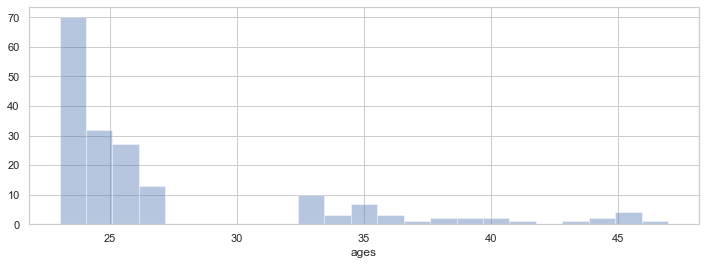

In [8]:
# ages evenly distributed, but they are obvious groupings for the range
f, ax = plt.subplots(figsize=(12,4))
sns.distplot(dff.ages, color="b", kde = False,  ax=ax)
plt.show()

In [9]:
# age target feature transformed to 5 ordinal age groups
tfm_age = dict.fromkeys(list(dff.ages.unique()), 0)
for i in list(dff.ages.unique()):
    if all([i >= 28, i <= 32]): tfm_age[i] = 1
    if all([i >= 33, i <= 37]): tfm_age[i] = 2
    if all([i >= 38, i <= 42]): tfm_age[i] = 3    
    if i >= 43: tfm_age[i] = 4
        

#### Occupation

The inital distribution of the occupation feature is shown below with 33 unique values. To reduce that number, the [U.S. Bureau of Labor Statistics Standard Occupational Classifications](https://www.bls.gov/soc/) system was referenced. From ther the 33 occupation were were grouped into  Eight of the major occupational groups along with an "other" and "student" as listed below:

1. Computer and Mathematical Occupations
1. Business and Financial Operations Occupations
2. Protective Service Occupations
3. Legal Occupations
4. Community and Social Service Occupations
5. Educational Instruction and Library Occupations
6. Arts, Design, Entertainment, Sports, and Media Occupations
7. Architecture and Engineering Occupations
8. other
9. students


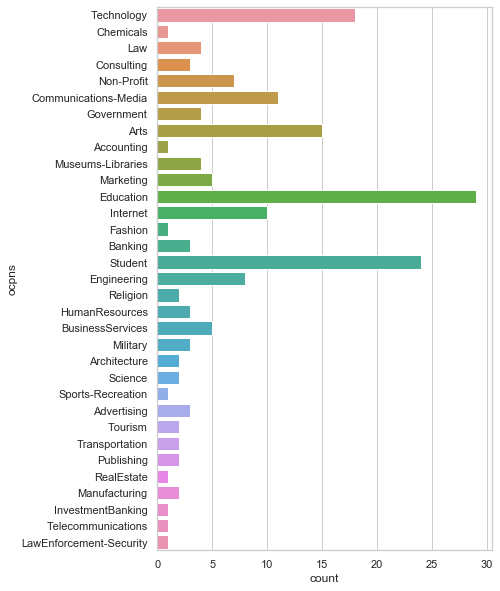

In [10]:
# iniitial occupation distribution
f, ax = plt.subplots(figsize=(6,10))
sns.countplot(y="ocpns", data=dff, ax=ax)
plt.show()

In [11]:
def group_upper(G):
    dct = {}; uppers = ascii_uppercase[0:len(G)]
    for (i,g) in enumerate(G):
        for key in g:
            dct[key] = uppers[i]
    return(dct)

ogrps = [['Technology', 'Internet'],['Consulting', 'Marketing', 'BusinessServices', 'Advertising', 'HumanResources',
         'Accounting', 'Banking', 'InvestmentBanking'],['Military','LawEnforcement-Security'],['Law'],
         ['Non-Profit','Religion', 'Government'], ['Education'], 
         ['Museums-Libraries', 'Arts', 'Communications-Media', 'Fashion', 'Sports-Recreation', 'Tourism', 'Publishing'],
         ['Engineering', 'Architecture', 'Science'],
         ['Transportation', 'Manufacturing','RealEstate', 'Telecommunications', 'Chemicals'],['Student']]


tfm_ocpn = group_upper(ogrps)
dff['ogrp'] = dff.ocpns.apply(lambda x: tfm_ocpn[x])

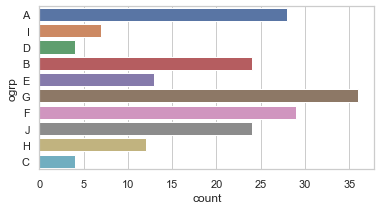

In [12]:
# occupation distribution after grouping
f, ax = plt.subplots(figsize=(6,3))
sns.countplot(y="ogrp", data=dff, ax=ax)
plt.show()

#### Sign
Check the distribution of the "sign" feature.  All 12 of the all important horoscope signs are included and relatively evenly distributed. For the US and United Kingdom, births per calender month are fairly well distributed with the typical peak birth month of August having about 12% more births than the February.  

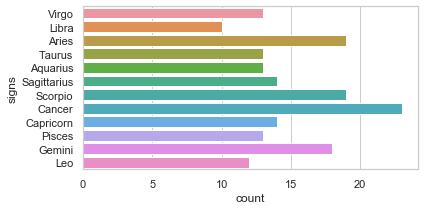

In [13]:
f, ax = plt.subplots(figsize=(6,3))
sns.countplot(y ="signs", data=dff, ax=ax)
plt.show()

#### Length of Post

In [14]:
from scipy.stats import percentileofscore

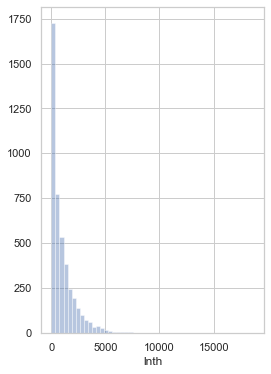

In [15]:
f, ax = plt.subplots(figsize=(4,6))
sns.distplot(dfb.lnth, color="b", kde = False,  ax=ax)
plt.show()

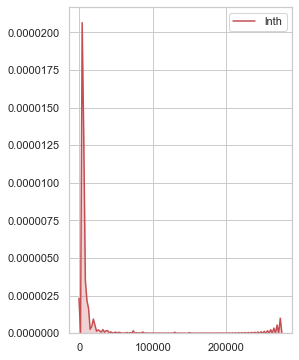

In [16]:
f, ax = plt.subplots(figsize=(4,6))
sns.kdeplot(dfa.lnth, shade=True, color="r", ax=ax)
plt.show()

#### Date of Post

In [17]:
def group_ts(ts, pr):
    assert all((pr[0].start_time <= ts, pr[len(pr) - 1].end_time >= ts))
    for i in range(len(pr)):
         if all((pr[i].start_time <= ts, pr[i].end_time >= ts)):
                return i; break

start = min([dfa.date.min(), dfb.date.min()])
end   = max([dfa.date.max(), dfb.date.max()])                      
pr = pd.period_range(start, end, freq='M')             

### Processing Feature Sets

In [18]:
# add the created features to DataFrames
dfa['prd']  = dfa.date.apply(lambda x: group_ts(x,pr))
dfa['ln_per'] = dfa.lnth.apply(lambda x: percentileofscore(dfa.lnth, x))
dfb['agrp'] = dfb.age.apply(lambda x: tfm_age[x])
dfb['ogrp'] = dfb.ocpn.apply(lambda x: tfm_ocpn[x])
dfb['prd']  = dfb.date.apply(lambda x: group_ts(x,pr))
dfb['ln_per'] = dfb.lnth.apply(lambda x: percentileofscore(dfb.lnth, x))

In [19]:
dfa.tail()

,blgr,date,post,lnth,prd,ln_per
8553,J,2004-08-01,\n\n\t \n urlLink CNN.com - Church bombs...,223,40,15.815611
8554,J,2004-08-01,\n\n\t \n urlLink CNN.com - Poll: No 'bo...,1216,40,57.431643
8555,J,2004-08-01,\n\n\t \n Welcome back from a pretty good...,301,40,21.325076
8556,J,2004-08-01,\n\n\t \n urlLink National Sales Tax?? ...,169,40,11.538911
8557,J,2004-08-01,"\n\n\t \n Hey, I have a request for every...",1512,40,65.669549


####  Checking Feature Correlations 

Full disclusure, this was done after running the inital supervised [classifiers](#init).  

There is a relatively high negative correlation between "gender" and "sign" reflecting some bias in the "B" data selection.  [Or does it](https://www.independent.co.uk/news/science/seasons-affect-sex-of-babies-study-reveals-592545.html)?    

In [20]:
# correlation matrix of feature set B non-NLP features
dfx = dfb.drop(['age', 'ocpn', 'date', 'lnth', 'post'], axis=1)
d_sign = {val:i for (i, val) in enumerate(dfb.sign.unique())}
d_ogrp = {val:i for (i, val) in enumerate(dfb.ogrp.unique())}  
dfx.gndr = np.where(dfx.gndr == 'male', 1, 0)
dfx.ogrp = dfx.ogrp.apply(lambda x: d_ogrp[x])
dfx.sign = dfx.sign.apply(lambda x: d_sign[x])
dfx.corr()

,gndr,sign,agrp,ogrp,prd,ln_per
gndr,1.000000,-0.191201,-0.049426,-0.085895,-0.043623,-0.158407
sign,-0.191201,1.000000,-0.061503,0.186825,-0.031210,0.139621
agrp,-0.049426,-0.061503,1.000000,0.029278,-0.105545,0.087469
ogrp,-0.085895,0.186825,0.029278,1.000000,-0.096949,0.046613
prd,-0.043623,-0.031210,-0.105545,-0.096949,1.000000,-0.020672
ln_per,-0.158407,0.139621,0.087469,0.046613,-0.020672,1.000000


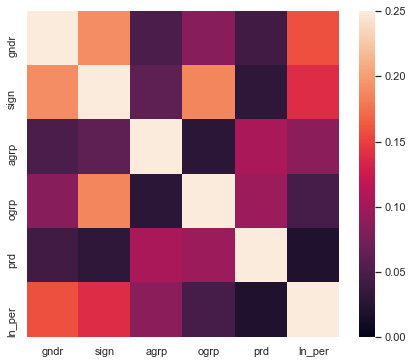

In [21]:
# heat map of correlation matrix, note vmax changed from 1 to 0.25
f, ax = plt.subplots(figsize=(7,6))
sns.heatmap(dfx.corr().abs(), vmin=0, vmax=.25, ax=ax)
plt.show()

In [22]:
# correlation matrix of feature set A blogger, period, length percentile feature
dfz = dfa.drop(['date', 'lnth', 'post'], axis=1)
d_blgr = {val:i for (i, val) in enumerate(dfa.blgr.unique())}  
dfz.blgr = dfz.blgr.apply(lambda x: d_blgr[x])
dfz.corr()

,blgr,prd,ln_per
blgr,1.00000,0.239620,-0.155860
prd,0.23962,1.000000,0.196815
ln_per,-0.15586,0.196815,1.000000


#### NLP Features <a name="feat"></a>
- Used bag of words and tf-idf methods to create features.
- sklearn CountVectorizer fit and transform for the bag of words sparse matrix and then TfidfTransformer to transform bag of words to the tf-idf sparse matrix.  

In [23]:
import nltk
from nltk.corpus import stopwords
import spacy
from spacy.lang.en import English
nlp = spacy.load("en_core_web_lg")

In [24]:
#tokenize, lemmaize, use both spaCy and ntlk stops
def lemma_post(doc):
    stops = stopwords.words('english') + ['urllink', 'urlLink']
    A = [d for d in doc if all([d.is_alpha, not d.is_stop])]
    B = [a for a in A if a.lemma_ not in stops]
    return  [b.lemma_ if all([b.pos_ == 'PROPN', not b.is_upper]) else b.lemma_.lower() for b in B]

assert lemma_post(nlp('urlLink www.dmbirc.org')) == []
assert lemma_post(nlp('Tom is FAT')) == ['Tom', 'fat']

In [25]:
dfa['lemma'] = dfa.post.apply(lambda x: lemma_post(nlp(x)))

#### Naming Convention for feature sets

Below is information for the various data sets used for modeling:

| Sample Set | Target Feature  | Target Number | NLP Feature | Other Features | Extension |
|-------     | -------         | --------------| ------       | ----------- | ----|
 A  | blogger | 1 | bow| yes | _a1wy
 A  | blogger | 1 | bow| no | _a1wn
 A  | blogger | 1 | lsa | yes | _a1sy 
 B | none | 0 | lsa | yes | _b0sy
 B  | gender  | 2 | lsa | yes | _b2sy
 B  | age group  | 3  | bo |  fst_b4 
 B  | occupation group | 4 | lsa |  fst_b5 
 B  | sign  | 5  | bow  |  fst_b6 

In [26]:
dfa.tail(2)

,blgr,date,post,lnth,prd,ln_per,lemma
8556,J,2004-08-01,\n\n\t \n urlLink National Sales Tax?? ...,169,40,11.538911,"[National, Sales, Tax, oh, let, true, Bush, ge..."
8557,J,2004-08-01,"\n\n\t \n Hey, I have a request for every...",1512,40,65.669549,"[hey, request, follow, page, answer, question,..."


In [27]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [28]:
def lsa_tfr():
    pipe = make_pipeline(TfidfVectorizer(lowercase=False, min_df=0.05, max_df=0.50), 
                     TruncatedSVD(n_components=100, random_state=5))
    return ColumnTransformer(sparse_threshold=0, transformers=[('lsa', pipe, 'post')])

In [29]:
def bow_tfr():
    pipe = make_pipeline(CountVectorizer(lowercase=False, min_df=0.05, max_df=0.50), 
                     TruncatedSVD(n_components=100, random_state=3)) 
    return ColumnTransformer(sparse_threshold=0, transformers=[('bow', pipe, 'post')])

In [30]:
# create 
def feature_sets(df, cats, nums, name):
    tfr1 = ColumnTransformer(transformers=[('cat', OneHotEncoder(categories='auto'), cats)], sparse_threshold=0)
    tfr2 = ColumnTransformer(transformers=[('num', MinMaxScaler(), nums)], sparse_threshold=0)
    if name == 'bow': tfr = bow_tfr()
    else:             tfr = lsa_tfr()
    union = make_union(tfr, tfr1, tfr2)
    
    return union.fit_transform(df)

In [35]:
# create 
def B_feature_sets(df,trgt):
    cats = ['gndr', 'agrp', 'ogrp', 'sign', 'prd'];  nums = ['ln_per']  
    cats.remove(trgt)
    tfr1 = ColumnTransformer(transformers=[('cat', OneHotEncoder(categories='auto'), cats)], sparse_threshold=0)
    tfr2 = ColumnTransformer(transformers=[('num', MinMaxScaler(), nums)], sparse_threshold=0)
    tfr = lsa_tfr()
    union = make_union(tfr, tfr1, tfr2)
    
    return union.fit_transform(df)

In [32]:
# modeling data from feature set A
cats = ['prd']; nums = ['ln_per']
prm_a1wy = {'df': dfa, 'cats':cats, 'nums':nums, 'name':'bow'}
X_a1wy = feature_sets(**prm_a1wy)
y_a1 = dfa.blgr

prm_a1sy = {'df': dfa, 'cats':cats, 'nums':nums, 'name':'lsa'}
X_a1sy = feature_sets(**prm_a1sy)
X_a1sn = lsa_tfr().fit_transform(dfa)

In [33]:
cats = ['gndr', 'agrp', 'ogrp', 'sign', 'prd'];  nums = ['ln_per'] 
X_bs_all = feature_sets(dfb, cats, nums, 'lsa')

In [36]:
trgts = ['gndr', 'agrp', 'ogrp', 'sign']
X2, X3, X4, X5 = (B_feature_sets(dfb,trgt) for trgt in trgts)

### Clustering

The results of clustering analysis were surprising, both good and bad.  Admittedly, I not do completely understand the results.  

In [37]:
from sklearn.cluster import AffinityPropagation, KMeans, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

#### Clustering Sample Set "A"
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.


In [38]:
# clustering sample set "A" with n=10
pred_a1sy_10 = KMeans(n_clusters=10, random_state=42).fit_predict(X_a1sy)
rslt_a1sy_10 = pd.crosstab(y_a1, pred_a1sy_10, rownames=['bloggers'], colnames=['cluster'])
rslt_a1sy_10

cluster,0,1,2,3,4,5,6,7,8,9
bloggers,,,,,,,,,,
A,70,62,53,437,60,69,303,74,147,62
B,6,6,0,77,0,9,3,4,4,4
C,43,78,117,45,32,135,6,125,124,27
D,0,31,11,382,0,0,694,0,8,0
E,33,14,7,416,100,34,252,15,42,75
F,0,0,80,2,0,0,37,0,0,0
G,56,40,30,351,66,52,870,43,70,38
H,47,97,50,138,44,47,56,68,110,59
I,60,90,80,192,44,73,40,62,113,44


In [39]:
def cluster_scores(true, pred):
    return [adjusted_rand_score(true,pred), 
            homogeneity_score(true,pred),
            completeness_score(true,pred)]

In [41]:
pred1 = AffinityPropagation().fit_predict(X_a1sy)
rslt1= pd.crosstab(y_a1, pred_a1sy_05, rownames=['bloggers'], colnames=['cluster'])

NameError: name 'pred_a1sy_05' is not defined

In [ ]:
rslt1

In [ ]:
# clustering sample set "A" with n=5
pred_a1sy_05 = KMeans(n_clusters=5, random_state=42).fit_predict(X_a1sy)
rslt_a1sy_05 = pd.crosstab(y_a1, pred_a1sy_05, rownames=['bloggers'], colnames=['cluster'])
rslt_a1sy_05

In [ ]:
pd.set_option('precision', 4)
pd.DataFrame([cluster_scores(y_a1, pred_a1sy_10), cluster_scores(y_a1, pred1), cluster_scores(y_a1, pred_a1sy_05)], 
             index=['Kmeans_n10', 'AfinityPropagation', 'Kmeans_n05'],
             columns=['Adjusted_Rand_Index', 'Homogeneity_Score', 'Completeness_Score'])

In [ ]:
# cross tabs for k means n=5 and Afinity Propgations are the same?
assert rslt1.all().all() == rslt_a1sy_05.all().all()

#### Data Set B Clustering

In [ ]:
trgts = ['gndr', 'agrp', 'ogrp', 'sign']
b_xs  = [X2, X3, X4, X5]
nums  = [2, 4, 10, 12]

In [ ]:
def B_Kmeans(X,trgt, nums):
    pred = KMeans(n_clusters=nums, random_state=5).fit_predict(X)
    ctab = pd.crosstab(dfb[trgt], pred, rownames=[trgt], colnames=['cluster'])
    scrs = cluster_scores(dfb[trgt], pred)
    return (ctab,scrs)

In [88]:
results_n_count = [B_Kmeans(b_xs[i], trgts[i], nums[i]) for i in range(4)]

In [94]:
results_n_5 = [B_Kmeans(b_xs[i], trgts[i], 5) for i in range(4)]

In [92]:
pd.DataFrame([scrs for (ctab, scrs) in results], index=trgts,
             columns=['Adjusted_Rand_Index', 'Homogeneity_Score', 'Completeness_Score'])

,Adjusted_Rand_Index,Homogeneity_Score,Completeness_Score
gndr,0.0145,0.0025,0.0043
agrp,0.0012,0.0035,0.0028
ogrp,0.0094,0.0137,0.0244
sign,0.0174,0.0227,0.0396


In [95]:
pd.DataFrame([scrs for (ctab, scrs) in results_n_5], index=trgts,
             columns=['Adjusted_Rand_Index', 'Homogeneity_Score', 'Completeness_Score'])

,Adjusted_Rand_Index,Homogeneity_Score,Completeness_Score
gndr,0.0410,0.0160,0.0119
agrp,0.0049,0.0054,0.0039
ogrp,0.0073,0.0081,0.0185
sign,0.0098,0.0114,0.0303


In [91]:
results[0][1]

[0.014523831751572108, 0.0025111299451281814, 0.004305457279354526]

In [90]:
results[1][0]

cluster,0,1,2,3
agrp,,,,
0,17,2386,243,901
2,4,448,41,124
3,1,78,13,41
4,2,82,14,43


In [98]:
pred_bs_all = KMeans(n_clusters=5, random_state=42).fit_predict(X_bs_all)

In [99]:
pd.crosstab([dfb.gndr], pred_bs_all, rownames=['Gender'], colnames=['cluster'])

cluster,0,1,2,3,4
Gender,,,,,
female,1720,0,0,0,0
male,0,613,748,674,683


In [101]:
cluster_scores(dfb.gndr, pred_bs_all)

[0.45228892045175895, 0.9999999999999997, 0.4406473526824152]

In [189]:
pd.crosstab([dfb.agrp], pred_b0sy, rownames=['Age Group'], colnames=['cluster'])

cluster,0,1,2,3,4
Age Group,,,,,
0,467,1320,671,532,480
2,119,270,64,79,83
3,33,61,2,20,17
4,9,60,27,23,22


In [190]:
pd.crosstab([dfb.ogrp], pred_b0sy, rownames=['Occupation Group'], colnames=['cluster'])

cluster,0,1,2,3,4
Occupation Group,,,,,
A,166,164,125,207,130
B,89,278,150,60,39
C,5,22,5,22,43
D,10,25,53,0,17
E,77,74,14,20,80
F,53,315,185,61,37
G,60,577,92,41,29
H,148,68,31,61,145
I,15,29,5,36,50


In [191]:
pd.crosstab([dfb.sign], pred_b0sy, rownames=['horoscope sign'], colnames=['cluster'])

cluster,0,1,2,3,4
horoscope sign,,,,,
Aquarius,187,73,9,37,60
Aries,15,175,87,48,75
Cancer,32,254,158,58,102
Capricorn,22,121,54,90,25
Gemini,14,202,73,76,66
Leo,55,132,30,17,22
Libra,57,34,165,41,95
Pisces,52,156,19,55,8
Sagittarius,45,96,34,34,31


### Neural Network Model 

A neural network model where token vectors are calculated using a CNN. The vectors are mean pooled and used as features in a feed-forward network. This architecture is usually less accurate than the ensemble, but runs faster.

As I prefer to used spaCy for the nlp processing, I am specifically using the CNN model in the the spaCy module as opposed to SKlearn.  While it took a while to understand and there was extra processing to format the data, the CNN runs much leaner and faster.  

As neural network modeling is a resource hog, I made the assumption that I would have to reduce the dataset to sucessfully.  After a two sample test to verify the code, I sampled the "A" datafame to reduce it to only 100 rows.  As I discovered a significant difference in the number of posts by my 10 bloggers, I "weighted" post samples to obtain close to the same number of samples for each blogger.  

Again because of resource and processing concerns, I start with only 10 iterations for the neural network with the idea I would increase the number of samples and CNN iterations as necessary.  It wasn't.

In [86]:
weight = {key: 1 /   (dfa.groupby('blgr').blgr.count()[key] / len(dfa)) for key in dfa.blgr.unique()}
dfa['weight'] = dfa.blgr.apply(lambda x: weight[x])
dfs = dfa.sample(n=100, weights='weight', random_state=19)
dfs.index = range(len(dfs))
pd.DataFrame([dfa.groupby('blgr').blgr.count(), dfs.groupby('blgr').blgr.count()], index=['dataset_count', 'sample_count'])

blgr,A,B,C,D,E,F,G,H,I,J
dataset_count,1337,113,732,1126,988,119,1616,716,798,1013
sample_count,12,11,9,9,9,9,10,10,8,13


In [59]:
# format needed for labels for spaCy classification
def make_cats_dict(label):
    dct = dict.fromkeys(list(dfa.blgr.unique()), False)
    dct[label] = True   
    return dct
# split into train / test
def split_data(data, split=0.8):
    split = int(len(data) * split)
    return (data[:split]), (data[split:])

In [96]:
targets = dfs.blgr.tolist()
texts   = dfs.post.tolist()

In [97]:
# data the way spacy wants as [(text, label),....] 
labels = [make_cats_dict(target) for target in targets]
data = [z for z in zip(texts, labels)]
train = data[:80]
test  = data[80:]
# remove the labels from the test data
test = [txt for (txt,lbl) in test]

In [62]:
nlp = spacy.load("en_core_web_lg")

In [63]:
# TextCategorizer into pipe
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')
# add labels
for label in dfa.blgr.unique():
    textcat.add_label(label)

In [68]:
# train textcat only
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    nlp.begin_training()
    # Loop for 10 iterations
    for itn in range(10):
        random.shuffle(train)
        losses = {}
        for batch in spacy.util.minibatch(data, size=1):
            texts = [nlp(text) for text, entities in batch]
            annotations = [{"cats": entities} for text, entities in batch]
            nlp.update(texts, annotations, losses=losses)
        #tracking the model progessing by printing losses
        if itn % 1 == 0:
            print(losses)

{'textcat': 119.35421710833907}
{'textcat': 68.04373112134635}
{'textcat': 51.14327340386808}
{'textcat': 31.73543624157901}
{'textcat': 17.870730082388036}
{'textcat': 14.491041358589428}
{'textcat': 10.146654829175532}
{'textcat': 5.547130366798228}
{'textcat': 4.180729283333676}
{'textcat': 2.701634184393697}


The output of the losses above looks good.  And the results below even better to the point that I could hand calculate the accuracy.  

CNN accuracy = 1.00

As I was dubious of the results, I did re-confirm all the data and results. The lowest probabiity for any one versus rest classifcation was 0.9807.   

In [100]:
len(predicts)

100

In [101]:
cats = [(nlp(text).cats) for text in test] 
# this is no very pythonesque, but it works 
predicts = [x[0] for x in [[k for k,v in cat.items() if v == max(cat.values())] for cat in cats]]
pd.DataFrame([predicts, dfs.blgr[80:]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,G,H,E,J,A,E,C,D,H,D,G,J,E,A,A,C,C,D,I,A
1,G,H,E,J,A,E,C,D,H,D,G,J,E,A,A,C,C,D,I,A


### Initial Supervised Classifiers <a name="classify"></a>

In [31]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_validate

#### Sample A Classification 
The results below of the initial modeling included:
  - Higher mean accuracy score with LSA features than "bag of words" features
  - An initial post "length" feature had had neglibile impact on the classifier accuracy.  Transforming the "length" to a percentile score created a worthwhile feature.  
  - The "period" and "length_percentile" features in combination improved the mean accuracy score
  
I was very impressed with my period feature specifcally after the initial classification.  That was because I had neglected to check for feature corrleations before I 

In [32]:
# check four different classifiers 
clf1 = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
clf2 = RandomForestClassifier(n_estimators=20, random_state=2)
clf3 = LinearSVC(random_state=3, max_iter=1500)
clf4 = SGDClassifier()
clfs = [clf1, clf2, clf3, clf4]

In [33]:
# A classification with bag of words
y = y_a1; X = X_a1wy
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y,  test_size=0.2, random_state=9)
scrs = [clf.fit(X_trn, y_trn).score(X_tst, y_tst) for clf in clfs]
pd.DataFrame([clfs,scrs], index=['classifier', 'accuracy']).T

C:\Users\chuck\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,classifier,accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.7034
1,"(DecisionTreeClassifier(class_weight=None, cri...",0.503517
2,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.694607
3,"SGDClassifier(alpha=0.0001, average=False, cla...",0.666471


In [57]:
# A classification with lsa
y = y_a1; X = X_a1sy
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y,  test_size=0.2, random_state=9)
scrs = [clf.fit(X_trn, y_trn).score(X_tst, y_tst) for clf in clfs]
pd.DataFrame([clfs,scrs], index=['classifier', 'accuracy']).T

,classifier,accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.708675
1,"(DecisionTreeClassifier(class_weight=None, cri...",0.554513
2,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.709261
3,"SGDClassifier(alpha=0.0001, average=False, cla...",0.696952


In [58]:
# A classification with lsa and without period and length
y = y_a1; X = X_a1sn
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y,  test_size=0.2, random_state=9)
scrs = [clf.fit(X_trn, y_trn).score(X_tst, y_tst) for clf in clfs]
pd.DataFrame([clfs,scrs], index=['classifier', 'accuracy']).T

,classifier,accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.575615
1,"(DecisionTreeClassifier(class_weight=None, cri...",0.470692
2,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.575615
3,"SGDClassifier(alpha=0.0001, average=False, cla...",0.556858


### Sample B Classification <a name="classify"></a>


In [34]:
scr2s = cross_validate(clf1, X2, dfb.gndr, cv=5)['test_score']
scr3s = cross_validate(clf1, X3, dfb.agrp, cv=5)['test_score']
scr4s = cross_validate(clf1, X4, dfb.ogrp, cv=5)['test_score']
scr5s = cross_validate(clf1, X5, dfb.sign, cv=5)['test_score']

In [45]:
results = pd.DataFrame([scr2s, scr3s, scr4s,scr5s], index=trgts, columns=['split_' + str(i) for i in range(1,6)])
results['mean'] = results.mean(axis=1) 
results['std']  = results.std(axis=1)
results

,split_1,split_2,split_3,split_4,split_5,mean,std
gndr,0.652921,0.610092,0.591743,0.500574,0.568312,0.584728,0.050387
agrp,0.691867,0.607798,0.700688,0.626866,0.694604,0.664365,0.038977
ogrp,0.284247,0.227950,0.187141,0.227586,0.195627,0.224510,0.034119
sign,0.118721,0.147766,0.143513,0.194253,0.067894,0.134430,0.041262


### Scratch   <a name="scratch"></a>

Save some of the superfluous code snippets that may be useful in the future. Plus any unit tests.  

In [102]:
dfs.tail(1)

,blgr,date,post,lnth,prd,ln_per,lemma,weight
99,A,2004-04-10,\n\n \n \n Blogger doesn't seem ...,177,36,12.134845,"[Blogger, work, today, course, post, kinda, us...",6.400898


In [103]:
# double checking that I had not cheated somehow.  
maxs=[]
for cat in cats:
    for k,v in cat.items():
        if v == max(cat.values()):
            maxs.append((k,v))

In [104]:
test[19]

"\n\n    \n       \n      Blogger doesn't seem to be working so well today.  Of course, posting about it is kinda useless, since it's not working and you won't see this post.\n      \n"

In [105]:
cats[19]

{'A': 0.9857666492462158,
 'B': 0.00042816458153538406,
 'C': 0.00023980230616871268,
 'D': 0.00024075692635960877,
 'E': 8.431278547504917e-05,
 'F': 6.273669714573771e-05,
 'G': 0.00013183275586925447,
 'H': 4.539787187241018e-05,
 'I': 0.0010240107076242566,
 'J': 0.004062049090862274}

In [106]:
predicts[19]

'A'

In [76]:
maxs

[('G', 0.9995852112770081),
 ('H', 0.9999306201934814),
 ('E', 0.9998462200164795),
 ('J', 0.9982249140739441),
 ('A', 0.989192545413971),
 ('E', 0.9995218515396118),
 ('C', 0.9985244870185852),
 ('D', 0.9985632300376892),
 ('H', 0.9963686466217041),
 ('D', 0.9949943423271179),
 ('G', 0.9948587417602539),
 ('J', 0.9938048124313354),
 ('E', 0.9993674159049988),
 ('A', 0.9848964214324951),
 ('A', 0.980679988861084),
 ('C', 0.9980013966560364),
 ('C', 0.9940387010574341),
 ('D', 0.999064028263092),
 ('I', 0.9880613088607788),
 ('A', 0.9857666492462158)]

In [43]:
# modeling data from feature set B Clustering
prm_b0sy = {'df': dfb, 'cats':['agrp', 'ogrp', 'sign', 'gndr', 'prd'], 'nums':['ln_per'], 'name':'lsa'}
X_b0sy = feature_sets(**prm_b0sy)

In [72]:
d_tgt = {2:'gndr', 3:'agrp', 4:'ogrp', 5:'sign'}

In [78]:
dct = {k: for k,v in d_tgt.items()}

In [68]:
# # modeling data from feature set B supervised classification
y_b2 = dfb.gndr; y_b3 = dfb.agrp; y_b4 = dfb.ogrp; y_b5 = dfb.sign
prm_b2sy = {'df': dfb, 'cats':['agrp', 'ogrp', 'sign' ], 'nums':['ln_per'], 'name':'lsa'}
X_b2sy = feature_sets(**prm_b2sy)
prm_b3sy = {'df': dfb, 'cats':['gndr', 'ogrp', 'sign' ], 'nums':['ln_per'], 'name':'lsa'}
X_b3sy = feature_sets(**prm_b3sy)
prm_b4sy = {'df': dfb, 'cats':['gndr', 'agrp', 'sign' ], 'nums':['ln_per'], 'name':'lsa'}
X_b42sy = feature_sets(**prm_b4sy)
prm_b5sy = {'df': dfb, 'cats':['gndr', 'agrp', 'ogrp' ], 'nums':['ln_per'], 'name':'lsa'}
X_b5sy = feature_sets(**prm_b5sy)

In [ ]:
scores = []
dct = {'A':('title', 'BoW'), 'C':('title', 'tfidf'), 'B':('author', 'BoW'), 'D':('author', 'tfidf'), 
       1:'LogisticRegression', 2:'RandomForestClassifier'}
for c in 'ABCD':
    for i in range(1,3):
        tup = eval(c); clf = eval('clf' + str(i))
        clf.fit(tup[0], tup[2])
        scores.append(pd.Series({'classifier': dct[i], 'target': dct[c][0], 'method': dct[c][1], 
                                 'train':clf.score(tup[0], tup[2]), 'test':clf.score(tup[1], tup[3])}))
    

In [ ]:
# data for 2 targets x 2 feature sets
y1 = df1.title; y2 = df1.author
X1_trn, X1_tst, y1_trn, y1_tst = train_test_split(X, y1,  test_size=0.2, random_state=9)
X2_trn, X2_tst, y2_trn, y2_tst = train_test_split(X, y2,  test_size=0.2, random_state=9)
X3_trn, X3_tst, y3_trn, y3_tst = train_test_split(Xt, y1, test_size=0.2, random_state=9)
X4_trn, X4_tst, y4_trn, y4_tst = train_test_split(Xt, y2, test_size=0.2, random_state=9)

In [ ]:
# save train / test data as tuples to more easily document initial 8 classifcations
A = train_test_split(X,  y1,  test_size=0.2, random_state=9)
B = train_test_split(X,  y2,  test_size=0.2, random_state=9)
C = train_test_split(Xt, y1,  test_size=0.2, random_state=9)
D = train_test_split(Xt, y2,  test_size=0.2, random_state=9)

In [ ]:
pd.DataFrame(scores)

In [ ]:
tfr_cat = Pipeline(steps=[('ohe', OneHotEncoder(categories='auto'))])
tfr_ord = Pipeline(steps=[('ord', OrdinalEncoder(categories='auto'))])
tfr_bow = Pipeline(steps=[('cvr',CountVectorizer(lowercase=False,min_df=0.01, max_df=0.50))])

In [ ]:
clf_bow = LogisticRegressionCV(cv=5, random_state=0, solver='lbfgs', multi_class='auto', max_iter=200).fit(X,  y2)
#clf_idf = LogisticRegressionCV(cv=5, random_state=0, solver='lbfgs', multi_class='auto', max_iter=200).fit(Xt, y2)

In [ ]:
print('Bag of words cross validation score: %.4f' % clf_bow.score(X, y2))
print('tf-idf cross validation score: %.4f' % clf_idf.score(X, y2))

In [ ]:
# classifier runs prior to increasing BoW feature number
svd = TruncatedSVD(n_components=300, random_state=3)
Xs = svd.fit_transform(X)
svd.explained_variance_ratio_.sum()

In [ ]:
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(X_trn, y_trn)
clf.score(X_tst, y_tst)

In [ ]:
# X1 features used to increase accuracy
vectorizer = CountVectorizer(lowercase=False,min_df=0.0005, max_df=0.50)
X1 = vectorizer.fit_transform(lemmas)
svd = TruncatedSVD(n_components=1000, random_state=3)
X1s = svd.fit_transform(X1)
print('explained variance ration: %.4f' % svd.explained_variance_ratio_.sum())
X_trn, X_tst, y_trn, y_tst = train_test_split(X1s, y2,  test_size=0.2, random_state=9)
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
clf.fit(X_trn, y_trn)
clf.score(X_tst, y_tst)

In [ ]:
def group_upper(G):
    dct = {}; uppers = ascii_uppercase[0:len(G)]
    for (i,g) in enumerate(G):
        for key in g:
            dct[key] = uppers[i]
    return(dct)

In [ ]:
# check that samples still match up with features
assert df1.shape[0] == X.shape[0]
assert df1.shape[0] == Xt.shape[0]
assert X.shape      == Xt.shape

In [ ]:
# initial combining the occupations based on similarity not sparcity
combine = [['Technology', 'Internet'],['Consulting', 'Marketing', 'BusinessServices', 'Advertising', 'HumanResources'],
          ['Chemicals', 'Science'],['Law'],['Non-Profit', 'Museums-Libraries', 'Arts'], 
          ['Communications-Media', 'Telecommunications'], ['Government'], ['Accounting'], ['Education'], ['Fashion'],
          ['Banking', 'InvestmentBanking'], ['Student'], ['Engineering'], ['Religion'], 
          ['Military','LawEnforcement-Security'], ['Architecture'], ['Sports-Recreation', 'Tourism'], ['Transportation'],
          ['Publishing'], ['RealEstate'], ['Manufacturing'],'Telecommunications']
        
assert group_upper(combine)['Consulting'] == 'B'
dct_tfm = group_upper(combine)


In [ ]:
scores = {}
clf1.fit(X3_trn, y3_trn)
scores = {'train': clf1.score(X3_trn, y3_trn), 'test': clf1.score(X3_tst, y3_tst)}
scores

In [ ]:
len(vectorizer.get_feature_names())

In [ ]:
df1.sentence[2]

In [ ]:
df1.sentence[2].lemma_

In [ ]:
lemmas[0:4]

In [ ]:
rx4.sub('test',raws[14][0:100])

In [ ]:
# entity dectection 
entities=[(i, i.label_, i.label) for i in nytimes.ents]

In [120]:
dfr = pd.DataFrame([fst_a1w[2], clu1, clu4, clu9], index = ['blogger', 'n_is_2',  'n_is_5', 'n_is_10']).T
dfr = dfr.sort_values(by='blogger')
dfr.index = range(len(dfr))
dfr.tail()

,blogger,n_is_2,n_is_5,n_is_10
6816,J,NaN,NaN,NaN
6817,J,NaN,NaN,NaN
6818,J,NaN,NaN,NaN
6819,J,NaN,NaN,NaN
6820,J,NaN,NaN,NaN


In [118]:
import thinc.extra.datasets
import random

In [119]:
def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    train_data, _ = thinc.extra.datasets.imdb()
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

In [ ]:
(train_texts, train_cats), (dev_texts, dev_cats) = load_data()
train_texts = train_texts[:n_texts]
train_cats = train_cats[:n_texts]
print(
    "Using {} examples ({} training, {} evaluation)".format(
        n_texts, len(train_texts), len(dev_texts)
    )
)
train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

In [78]:
import spacy
from spacy.lang.en import English
nlp = spacy.load("en_core_web_lg")
import random
TRAINING_DATA = [    ["My little kitty is so special", {"KAT": True, "FAT":False}],
    ["Dude, Totally, Yeah, Video Games", {"KAT": False, "FAT":True}],
    ["Should I pay $1,000 for the iPhone X?", {"KAT": False, "FAT":True}],
    ["The iPhone 8 reviews are here", {"KAT": False, "FAT":True}],
    ["Noa is a great cat name.", {"KAT": True, "FAT":False}],
    ["We got a new kitten!", {"KAT": True, "FAT":False}]]